In [1]:
import numpy as np
import pylhe
import matplotlib.pyplot as plt
import fastjet as fj
import time

In [2]:
file1 = "./emep_ttx_bbx4j_events_showered2.lhe.gz"
file2 = "./emep_ttx_bbx4j_events2.lhe.gz"

In [3]:
events_showered = pylhe.read_lhe(file1)
events = pylhe.read_lhe(file2)

In [4]:
# Perform FastJet clustering on showered data
def fastjet_clustering(data, R):
    fj_particles = [fj.PseudoJet(px, py, pz, e) for eta, phi, pt, e, px, py, pz in data]
    jet_def = fj.JetDefinition(fj.cambridge_algorithm, R)
    fastjet_cluster_sequence = fj.ClusterSequence(fj_particles, jet_def)
    fastjet_clusters = fastjet_cluster_sequence.inclusive_jets(ptmin=5.0)
    print(len(fastjet_clusters))
    return fastjet_clusters, fj_particles

In [5]:
def delta_r(p1, p2, R):
    delta_eta = p1[0] - p2[0]
    delta_phi = np.abs(p1[1] - p2[1])
    if delta_phi > np.pi:
        delta_phi = 2 * np.pi - delta_phi
    delta_R2 = delta_eta**2 + delta_phi**2
    return delta_R2 / R**2

def calculate_sigma(pseudojet):
    n = len(pseudojet)
    if n < 2:
        return 0.0
    pT_weights = np.array([p[2] for p in pseudojet])
    total_pT = np.sum(pT_weights)
    delta_Rs = [delta_r(p1, p2, 1.0) for i, p1 in enumerate(pseudojet) for j, p2 in enumerate(pseudojet) if i < j]
    weighted_sum = np.sum([w1 * w2 * dR for (w1, w2, dR) in zip(pT_weights, pT_weights, delta_Rs)])
    weighted_mean = weighted_sum / total_pT**2
    weighted_sum_sq = np.sum([(w1 * w2 * dR)**2 for (w1, w2, dR) in zip(pT_weights, pT_weights, delta_Rs)])
    variance = (weighted_sum_sq / total_pT**2) - weighted_mean**2
    if variance < 0:
        variance = 0
    sigma_i = np.sqrt(variance)
    return sigma_i

def merge_particles(data, imin, jmin):
    px_sum = data[imin, 4] + data[jmin, 4]
    py_sum = data[imin, 5] + data[jmin, 5]
    pz_sum = data[imin, 6] + data[jmin, 6]
    E_sum = data[imin, 3] + data[jmin, 3]

    pt_sum = np.sqrt(px_sum**2 + py_sum**2)
    magn_p = np.sqrt(px_sum**2 + py_sum**2 + pz_sum**2)
    eta_sum = 0.5 * np.log((magn_p + pz_sum) / (magn_p - pz_sum))
    phi_sum = np.arctan2(py_sum, px_sum)
    if phi_sum > np.pi:
        phi_sum = -2 * np.pi + phi_sum
    elif phi_sum < -np.pi:
        phi_sum = 2 * np.pi + phi_sum

    data = np.vstack([data, [eta_sum, phi_sum, pt_sum, E_sum, px_sum, py_sum, pz_sum]])
    return data

def update_dis(new_row, dist_matrix):
    size = dist_matrix.shape[0] + 1
    new_dist_matrix = np.zeros((size, size))
    new_dist_matrix[:-1, :-1] = dist_matrix
    new_dist_matrix[-1,:] = new_row
    new_dist_matrix[:-1,-1] = new_row[:-1]
    new_dist_matrix[-1,-1] = np.inf
    if np.min(new_dist_matrix) < 1e-2:
        indices = np.unravel_index(np.argmin(new_dist_matrix), new_dist_matrix.shape)
        new_dist_matrix[indices[0],indices[1]] = np.inf
    return new_dist_matrix

def find_daughters(binary_tree, index, given_index):
    daughters = []

    # Base case: if index is not in the tree, return empty list
    if index not in binary_tree:
        return daughters

    # Recursive case
    node = binary_tree[index]
    if 'left' in node:
        left_index = node['left']
        if left_index < given_index:
            daughters.append(left_index)
        daughters.extend(find_daughters(binary_tree, left_index, given_index))
    if 'right' in node:
        right_index = node['right']
        if right_index < given_index:
            daughters.append(right_index)
        daughters.extend(find_daughters(binary_tree, right_index, given_index))

    return daughters

In [6]:
def Custom_dynrad(R, data):
    start_time = time.time()
    dendogram = []
    merge_count = 0
    jets, mergers, jets_constituents = [], [], []
    n_particles = data.shape[0]
    distances = np.full((n_particles, n_particles), np.inf)
    pseudojets = {i: [data[i]] for i in range(n_particles)}

    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            R_di = R + calculate_sigma(pseudojets[i])#
            distances[i, j] = delta_r(data[i], data[j], R_di)
            distances[j, i] = distances[i, j]
    dist_matrix = np.copy(distances)

    np.set_printoptions(linewidth=np.inf)

    while True:
        indices = np.unravel_index(np.argmin(dist_matrix, axis=None), dist_matrix.shape)
        min_dist = dist_matrix[indices[0], indices[1]]
        if min_dist < R:
            data = merge_particles(data, indices[0], indices[1])
            dendogram.append([merge_count + n_particles, indices[0], indices[1], min_dist])
            merge_count += 1

            new_index = data.shape[0] - 1
            pseudojets[new_index] = pseudojets.pop(indices[0]) + pseudojets.pop(indices[1])

            append_R = [delta_r(data[j], data[-1], R + calculate_sigma(pseudojets[j])) if j in pseudojets else np.inf for j in range(data.shape[0])]
            dist_matrix = update_dis(append_R, dist_matrix)
            dist_matrix[indices[0], :], dist_matrix[indices[1], :] = np.inf, np.inf
            dist_matrix[:, indices[0]], dist_matrix[:, indices[1]] = np.inf, np.inf
            for i, j, k, _ in dendogram:
                dist_matrix[j, :], dist_matrix[k, :] = np.inf, np.inf
                dist_matrix[:, j], dist_matrix[:, k] = np.inf, np.inf

        elif min_dist >= R and min_dist < np.inf:
            if indices[0] not in mergers and indices[1] not in mergers:
                jets.append(data[indices[0]])
                jets.append(data[indices[1]])
                mergers.append(indices[0])
                mergers.append(indices[1])
                for merge in mergers:
                    dist_matrix[merge, indices[0]], dist_matrix[indices[0], merge] = np.inf, np.inf
                    dist_matrix[merge, indices[1]], dist_matrix[indices[1], merge] = np.inf, np.inf
            if indices[0] in mergers and indices[1] not in mergers:
                jets.append(data[indices[1]])
                mergers.append(indices[1])
                for merge in mergers:
                    dist_matrix[merge, indices[1]], dist_matrix[indices[1], merge] = np.inf, np.inf
            if indices[0] not in mergers and indices[1] in mergers:
                jets.append(data[indices[0]])
                mergers.append(indices[0])
                for merge in mergers:
                    dist_matrix[merge, indices[0]], dist_matrix[indices[0], merge] = np.inf, np.inf

        elif min_dist == np.inf:
            print(f"Loop Broken in {round(time.time() - start_time, 4)}s")
            break

    t = time.time()
    tree = {}
    dendogram = np.array(dendogram)
    for entry in dendogram:
        merged_index, index1, index2, _ = entry
        if merged_index not in tree:
            tree[merged_index] = {'left': index1, 'right': index2}
        else:
            print(f"Node {merged_index} is already defined in the tree.")

    for merge in mergers:
        children = []
        children = find_daughters(tree, merge, n_particles)
        jet_constituents = []
        for child in children:
            jet_constituents.append(all_event_s[int(child)])
        jets_constituents.append(jet_constituents)
    print(f"Time taken for finding constituents {round(time.time() - t, 6)}s")

    return jets, jets_constituents, tree, mergers

In [7]:
particles = []
all_event = []
i = 0
for event in events:
    particl = []
    i += 1
    for particle in event.particles:
        if particle.status == 1:  # Only stable particles
            px, py, pz, E = particle.px, particle.py, particle.pz, particle.e
            eta = 0.5 * np.log((np.sqrt(px**2 + py**2 + pz**2) + pz) / (np.sqrt(px**2 + py**2 + pz**2) - pz))
            phi = np.arctan2(py, px)
            pt = np.sqrt(px**2 + py**2)
            particles.append([eta, phi, pt, E, px, py, pz])
            particl.append([eta, phi, pt, E, px, py, pz])
    if i > 1000:
        break
    all_event.append(particl)

particle_data = np.array(particles)

In [8]:
particles_s = []
all_event_s = []
j = 0
for event_s in events_showered:
    particl_s = []
    j += 1
    for particle in event_s.particles:
        if particle.status == 1:  # Only stable particles
            px, py, pz, E = particle.px, particle.py, particle.pz, particle.e
            eta = 0.5 * np.log((np.sqrt(px**2 + py**2 + pz**2) + pz) / (np.sqrt(px**2 + py**2 + pz**2) - pz))
            phi = np.arctan2(py, px)
            pt = np.sqrt(px**2 + py**2)
            particles_s.append([eta, phi, pt, E, px, py, pz])
            particl_s.append([eta, phi, pt, E, px, py, pz])
    if j > 1000:
        break
    all_event_s.append(particl_s)

particle_data_s = np.array(particles_s)



In [9]:
R = 0.5  # Jet radius parameter
fastjet_clusters_showered, fastjet_part = fastjet_clustering(all_event_s[50], R)

6#--------------------------------------------------------------------------
#                         FastJet release 3.4.1

#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [10]:
R = 0.5 
jets_r, jets_constituents1, tree1, mergers1 = Custom_dynrad(R, np.array(all_event_s[50]))


Loop Broken in 0.6629s
Time taken for finding constituents 0.001047s


Text(0, 0.5, '$\\phi$')

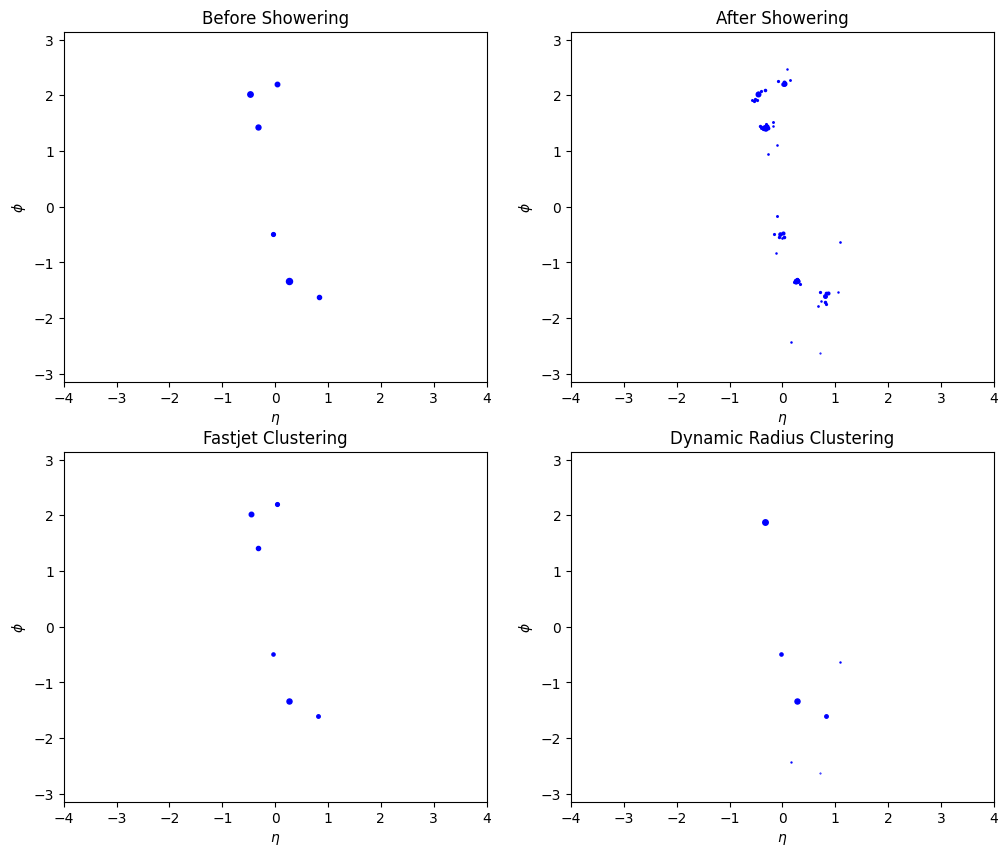

In [11]:
fig, axes = plt.subplots(2,2, figsize=(12,10))

for i in all_event[50]:
    axes[0,0].scatter(i[0],i[1],s=np.sqrt(i[3]), color = 'blue')
axes[0,0].set_ylim(-np.pi,np.pi)
axes[0,0].set_xlim(-4,4)
axes[0,0].set_title('Before Showering')
axes[0,0].set_xlabel(r'$\eta$')
axes[0,0].set_ylabel(r'$\phi$')

for jm in fastjet_clusters_showered:
    pih=jm.phi()
    if pih>np.pi:
        pih=pih-2*np.pi
    if pih<-np.pi:
        pih=pih+2*np.pi
    #print(f"Jet: pt = {jet.pt()}, eta = {jet.eta()}, phi = {ph}, e = {jet.e()}")
    axes[1,0].scatter(jm.eta(), pih, s=np.sqrt(jm.e()*0.5), color = 'blue')
axes[1,0].set_ylim(-np.pi,np.pi)
axes[1,0].set_xlim(-4,4)
axes[1,0].set_title('Fastjet Clustering')
axes[1,0].set_xlabel(r'$\eta$')
axes[1,0].set_ylabel(r'$\phi$')

for j in all_event_s[50]:
    axes[0,1].scatter(j[0],j[1],s=np.sqrt(j[3]), color = 'blue')
axes[0,1].set_ylim(-np.pi,np.pi)
axes[0,1].set_xlim(-4,4)
axes[0,1].set_title('After Showering')
axes[0,1].set_xlabel(r'$\eta$')
axes[0,1].set_ylabel(r'$\phi$')

for jet in jets_r:
    # Only plot jets with energy > 5 GeV
    #if jet[3] > 5.0:
    axes[1,1].scatter(jet[0], jet[1], s=np.sqrt(jet[3] * 0.5), color = 'blue')
axes[1,1].set_ylim(-np.pi,np.pi)
axes[1,1].set_xlim(-4,4)
axes[1,1].set_title('Dynamic Radius Clustering')
axes[1,1].set_xlabel(r'$\eta$')
axes[1,1].set_ylabel(r'$\phi$')

## Comparison between Old custom and Dyn Rad Algorithm


In [13]:
def Custom_CA(R:float, data:np.array):
    start_time = time.time()
    dendogram = []
    merge_count = 0
    jets, mergers, jets_constituents = [],[],[]
    n_particles = data.shape[0]
    distances = np.full((n_particles, n_particles), np.inf)
    
    # Calculate the distance matrix and beam distances
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            distances[i, j] = delta_r(data[i], data[j], R)
            distances[j, i] = distances[i, j]
    dist_matrix = np.copy(distances)
    
    np.set_printoptions(linewidth=np.inf)
    
    while(1):
        indices = np.unravel_index(np.argmin(dist_matrix, axis=None), dist_matrix.shape)
        min_dist = dist_matrix[indices[0], indices[1]]
        if min_dist < R:
            data = merge_particles(data, indices[0], indices[1])
            dendogram.append([merge_count+n_particles,indices[0],indices[1],min_dist])
            merge_count+=1
            append_R = [delta_r(data[j], data[-1], R) for j in range(data.shape[0])]
            dist_matrix = update_dis(append_R, dist_matrix)
            dist_matrix[indices[0],:], dist_matrix[indices[1],:] = np.inf, np.inf
            dist_matrix[:,indices[0]], dist_matrix[:,indices[1]] = np.inf, np.inf
            for i,j,k,_ in dendogram:
                dist_matrix[j,:], dist_matrix[k,:] = np.inf, np.inf
                dist_matrix[:,j], dist_matrix[:,k] = np.inf, np.inf
        
        elif min_dist >= R and min_dist < np.inf:
            if (indices[0] not in mergers) and (indices[1] not in mergers):
                jets.append(data[indices[0]])
                jets.append(data[indices[1]])
                mergers.append(indices[0])
                mergers.append(indices[1])
                for merge in mergers:
                    dist_matrix[merge,indices[0]], dist_matrix[indices[0],merge] = np.inf, np.inf
                    dist_matrix[merge,indices[1]], dist_matrix[indices[1],merge] = np.inf, np.inf
            if (indices[0] in mergers) and (indices[1] not in mergers):
                jets.append(data[indices[1]])
                mergers.append(indices[1])
                for merge in mergers:
                    dist_matrix[merge,indices[1]], dist_matrix[indices[1],merge] = np.inf, np.inf
            if (indices[0] not in mergers) and (indices[1] in mergers):
                jets.append(data[indices[0]])
                mergers.append(indices[0])
                for merge in mergers:
                    dist_matrix[merge,indices[0]], dist_matrix[indices[0],merge] = np.inf, np.inf
                
        elif min_dist == np.inf:
            # mergers.append(data.shape[0]-1)
            print(f"Loop Broken in {round(time.time()-start_time,4)}s")
            break

    t = time.time()
    tree = {} 
    dendogram = np.array(dendogram)
    for entry in dendogram:
        merged_index, index1, index2,_ = entry
        if merged_index not in tree:
            tree[merged_index] = {'left': index1, 'right': index2}
        else:
            print(f"Node {merged_index} is already defined in the tree.")
    
    for merge in mergers:
        children = []
        children = find_daughters(tree, merge, n_particles)
        jet_constituents = []
        for child in children:
            jet_constituents.append(all_event_s[int(child)])
        jets_constituents.append(jet_constituents)
    print(f"Time taken for finding consitutents {round(time.time()-t,6)}s")
        
    return jets, jets_constituents, tree, mergers

In [14]:
jets_c, jets_constituents2, tree2, mergers2 = Custom_CA(R, np.array(all_event_s[50]))


Loop Broken in 0.2712s
Time taken for finding consitutents 0.000979s


Text(0, 0.5, '$\\phi$')

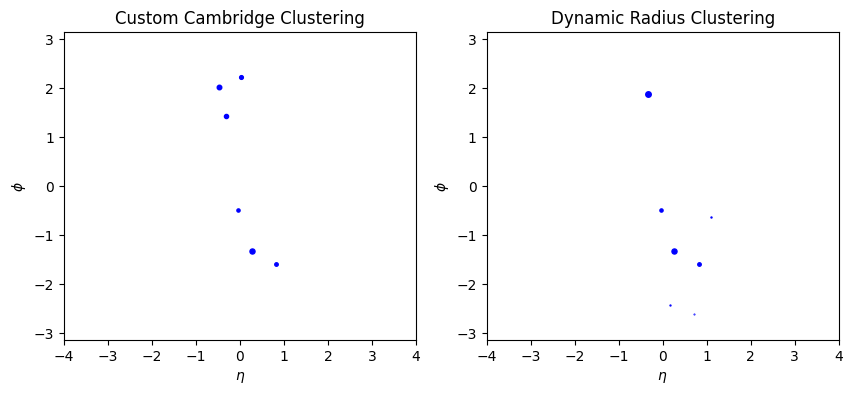

In [17]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

for jet in jets_c:
    # Only plot jets with energy > 5 GeV
    if jet[3] > 5.0:
        axes[0].scatter(jet[0], jet[1], s=np.sqrt(jet[3] * 0.5), color = 'blue')
axes[0].set_ylim(-np.pi,np.pi)
axes[0].set_xlim(-4,4)
axes[0].set_title('Custom Cambridge Clustering')
axes[0].set_xlabel(r'$\eta$')
axes[0].set_ylabel(r'$\phi$')

for jet in jets_r:
    # Only plot jets with energy > 5 GeV
    #if jet[3] > 5.0:
    axes[1].scatter(jet[0], jet[1], s=np.sqrt(jet[3] * 0.5), color = 'blue')
axes[1].set_ylim(-np.pi,np.pi)
axes[1].set_xlim(-4,4)
axes[1].set_title('Dynamic Radius Clustering')
axes[1].set_xlabel(r'$\eta$')
axes[1].set_ylabel(r'$\phi$')